<a href="https://colab.research.google.com/github/busy-bison/colab/blob/main/dotplot_tukey_dunnett.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###【使い方】（詳細や検定結果の見かたについてはドキュメントを参照ください）
1. 入力データの準備について  
↓エクセルでデータをまとめた表を作成してください。一番上の行には、各列の名称を記入してください。  
↓「名前をつけて保存」から、csvファイルとして「入力.csv」という名称で出力し、適当な場所に保存してください。  
 
2. このノートブックの使い方について  
↓画面左側のタブから、一番下のフォルダマークを選択してください。  
↓先ほど出力した「入力.csv」ファイルをドラッグ&ドロップでアップロードしてください。  
↓データの列名等に合わせ、「① 設定」を変更してください。変更後、左上のスタートボタンを押してください。  
↓「② dotplot」、「③ Tukey検定」、「④ Dunnett検定」のうち、必要なものを選んでスタートボタン（セル左上の［］にカーソルを合わせるとボタンに変わります）から実行してください。   
↓実行が完了したあと、左側のタブに表示されている「更新」（フォルダ + 巻矢印）ボタンをクリックしてください。  
↓作成されたファイルのうち、必要なものをダウンロードしてください。 実行セルごとに作成されるファイルは以下の通りです。
  - ② dotplot
    - 図.png：作成されたdotplot
    - summary.csv：各カテゴリの平均値、標準誤差、サンプル数
  - ③ Tukey検定
    - Tukey結果.txt：Tukey検定の結果
  - ④ Dunnett検定
    - Dunnett結果.txt：Dunnett検定の結果

### 【エラーが起きたときは】
- "KeyError"と表示された場合
  - `COL_X`、`COL_Y`、`HUE`のいずれかがデータの列名と一致していない可能性があります。
- グラフ中で点やラベルが重なっている場合
  - `FIGSIZE`や`LABELROTATION`、`FONTSIZE`などの設定を変更してみてください。

## ① 設定
↓変更後、実行ボタンを押してください

In [5]:
### この部分を設定してください。 ###
COL_X = "strain"  # 横軸のデータが格納された列名
COL_Y = "chemotaxis index"  # 縦軸のデータが格納された列名
HUE = "conditioning"  # COL_X列（例えばstrain）のラベルが同じサンプルの中で（例えばconditioningごとに）さらに色分けする場合、その色分けに用いるデータが格納された列名
# HUE = None  # COL_X列のラベルが同じサンプルの中でのさらなる色分けを行わない場合、この行の先頭の#を消してください。
PALETTE_DICT = {"condition A": "blue",
                "condition B": "green",
                "condition C": "red",
                }  # 色分けに用いるラベルと色の対応（設定されていないラベルの色は自動で決まります）
TITLE = "test"  # グラフのタイトル
DUNNETT_CONTROL_LABEL = "N2"  # Dunnett検定におけるコントロール（COL_X列に含まれるラベル）
FIGSIZE = (6.4, 4.8)  # グラフのサイズ（横方向, 縦方向の順）デフォルトは(6.4, 4.8)
YLIM = (-1.2, 1.2)  # 縦軸の（下限, 上限）
YTICKS = [-1.0, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]  # 縦軸のラベルを打つ位置
LABELROTATION = 0  # 横軸のラベルの回転角度（0：水平、90：垂直。45とかもできます）
FONTSIZE = 15  # フォントサイズ（デフォルトは15）
DOTPLOT_POINTSIZE = 5  # dotplotの点のサイズ（デフォルトは5）
ERRORBAR_CENTERBARSIZE = 10  # エラーバーの中央（平均を示す部分）の棒のサイズ（デフォルトは10）
ERRORBAR_CAPSIZE = 10  # エラーバーの上下（標準誤差を示す部分）の棒のサイズ（デフォルトは10）
### 設定終わり ###

# RILアッセイ用
SORTING = {"sort": "no",  # 縦軸の値の順に並べるか（"no"/"ascending"/"descending"）
           "left": "no",   # sortが"no"でないとき、一番左に置くコントロール。設定しない場合は"no"
           "right": "no",   # sortが"no"でないとき、一番右に置くコントロール。設定しない場合は"no"
           } # ※ソートできるのはHUE = None、またはHUEのラベルが1種類のみの場合

INPUT_CSV_PATH = "/content/入力.csv"  # csvファイル入力用パス

!pip install japanize-matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib, japanize_matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# データ入力
try:
  df = pd.read_csv(INPUT_CSV_PATH)
except UnicodeDecodeError:
  df = pd.read_csv(INPUT_CSV_PATH, encoding = "shift-jis")

# 全てが空白の列や行を削除
df = df.dropna(how = "all")

## ② dotplot
↓ボタンを押して実行してください

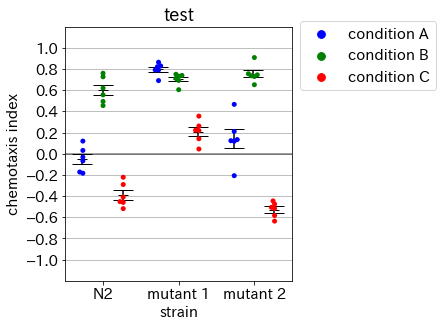

In [6]:
def get_swarm_pos(ax, order, hue_order, dodge):
    # swarmplotをplt.plotで描けるように座標をとってくる
    # axはすでにswarmplotを描いてあるもの

    # 戻り値は, hueがNoneの場合はxをキー、(x, y)を値とするディクショナリ
    # hueがある場合はその中にhueをキーとして入れ子にする
    # swarm_pos[x][hue]で目的とするカテゴリの座標が得られる

    swarm_pos = {o: {} for o in order}  # 結果格納用ディクショナリ。orderの分は設定しておかないとx。

    # ディクショナリのキー
    if hue_order:
        key_list = [(o, ho) for o in order for ho in hue_order]
    else:
        key_list = order

    # カテゴリごとにy座標を取得
    c = ax.get_children()
    ## x, y = c[i]のとき、len(x)はi >= (カテゴリの個数)で0になる
    i = 0
    while True:
        if isinstance(c[i], matplotlib.collections.PathCollection):
            x, y = c[i].get_offsets().T
            if len(x) != 0:
                if hue_order and dodge:
                    swarm_pos[key_list[i][0]][key_list[i][1]] = (x, y)
                else:
                    swarm_pos[key_list[i]] = (x, y)
            else:
                pass
        else:
            break
        i += 1

    return swarm_pos

def get_errorbar_inputs(xvalues, yvalues):

    xpos = [xvi.mean() for xvi in xvalues]
    ymean = [yvi.mean() for yvi in yvalues]
    yerr = [yvi.std(ddof = 1) / (len(yvi) ** 0.5) for yvi in yvalues]

    return xpos, ymean, yerr

def swarmplot_and_errorbar(ax, x, y, data, hue, order, hue_order, palette, pointsize, markersize, capsize):
    # 与えられたaxの上にswarmplotを描き、その上にerrorbarを重ねる

    # matplotlibの設定
    plt.rcParams["font.size"] = FONTSIZE

    # swarmplot描画
    sns.swarmplot(x = x, y = y, data = data, hue = hue, order = order, hue_order = hue_order, ax = ax, palette = palette, size = pointsize, dodge = True)

    # 各swarmの座標を取得
    swarm_pos = get_swarm_pos(ax = ax, order = order, hue_order = hue_order, dodge = True)

    # 各カテゴリのラベル
    if hue:
        label_list = [f"{o}_{ho}" for o in order for ho in swarm_pos[o].keys()]
    else:
        label_list = order

    if hue_order:
        xvalues = [swarm_pos[o][ho][0] for o in order for ho in hue_order if ho in swarm_pos[o].keys()]
        yvalues = [np.array(data[(data[x] == o) & (data[hue] == ho)][y]) for o in order for ho in hue_order if ho in swarm_pos[o].keys()]

    else: # hue = None
        xvalues = [swarm_pos[o][0] for o in order]
        yvalues = [np.array(data[(data[x] == o)][y]) for o in order]

    xpos, ymean, yerr = get_errorbar_inputs(xvalues = xvalues, yvalues = yvalues)

    ax.errorbar(xpos, ymean, yerr, fmt = "_", color = "k", markersize = markersize, capsize = capsize)

    # 結果
    result_summary = pd.DataFrame(index = ["平均", "標準誤差", "サンプル数"],
                                  columns = label_list,
                                  data = [ymean, yerr, [int(len(yvi)) for yvi in yvalues]])
    result_summary = result_summary.T
    result_summary = result_summary.astype({"サンプル数": "int"})

    return ax, result_summary


# グラフデザインのセット
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['IPAexGothic']

# order
order = list(df[COL_X].unique())
if (SORTING["sort"] == "ascending") or (SORTING["sort"] == "descending"):
    # orderを縦軸データの大小で並べ替え
    list_of_means = [(df[COL_Y][df[COL_X] == o].mean(), o) for o in order]
    list_of_means.sort(reverse = (SORTING["sort"] == "descending"), key = lambda x: x[0])
    ## order書き換え
    if (SORTING["right"] == "no" and SORTING["left"] == "no"):
        for idx, (_, new_o) in enumerate(list_of_means):
            order[idx] = new_o
    else:
        idx = 1
        for _, new_o in list_of_means:
            # print(idx, new_o, type(new_o), new_o == ORDER["left"], new_o == ORDER["right"])
            if (new_o == SORTING["left"] or new_o == SORTING["right"]): continue 
            order[idx] = new_o
            idx += 1
        order[0] = SORTING["left"] 
        order[-1] = SORTING["right"]

# hue
if HUE:
    hue_order = list(df[HUE].unique())
    palette = {}
    # デフォルト設定に含まれるhueのみなら色は固定される。未知のhueがある場合はランダムな色。
    for ho in hue_order:
        try:
            palette[ho] = PALETTE_DICT[ho]
        except KeyError:
            palette = None
            break
else:
    hue_order = None
    palette = {}
    # デフォルト設定に含まれるlabelのみなら色は固定される。未知のlabelがある場合はランダムな色。
    for o in order:
        try:
            palette[o] = PALETTE_DICT[o]
        except KeyError:
            palette = None
            break


# swarmplot, errorbar描画
fig, ax = plt.subplots(figsize = FIGSIZE)
ax, result_summary = swarmplot_and_errorbar(ax = ax,
                                            x = COL_X,
                                            y = COL_Y,
                                            data = df,
                                            hue = HUE,
                                            order = order,
                                            hue_order = hue_order,
                                            palette = palette,
                                            pointsize = DOTPLOT_POINTSIZE,
                                            markersize = ERRORBAR_CENTERBARSIZE,
                                            capsize = ERRORBAR_CAPSIZE)

# グラフの設定
ax.set(title = TITLE, ylim = YLIM, yticks = YTICKS)
ax.plot([-0.5, len(order) - 0.5], [0, 0], c = "k", alpha = 0.5)
ax.legend(bbox_to_anchor = (1, 1.05), loc = "upper left", fontsize = FONTSIZE)
ax.tick_params(axis = "x", labelrotation = LABELROTATION)
ax.grid(axis = "y")

# 結果出力
result_summary.to_csv("/content/summary.csv")

# 図の保存と表示
fig.tight_layout()
fig.savefig("/content/図.png", dpi = 400, facecolor = "w")
fig.show()

## ③ Tukey検定
↓ボタンを押して実行してください

In [5]:
def tukey_hsd_r(values, labels, sub_labels = None):
    # values: list 値
    # labels: list 各値のグループ名
    # sub_labels: list グループ分けに用いる、各値のラベル。指定するとsub_labelごとに分けてtukey検定が実行される。

    if sub_labels:
        df_tmp = pd.DataFrame({"value": values,
                               "label": labels,
                               "sub_label": sub_labels})

        sub_label_list = list(df_tmp["sub_label"].unique())
        value_groups = [list(df_tmp[df_tmp["sub_label"] == sl]["value"]) for sl in sub_label_list]
        label_groups = [list(df_tmp[df_tmp["sub_label"] == sl]["label"]) for sl in sub_label_list]
    else:
        sub_label_list = [None]
        value_groups = [values]
        label_groups = [labels]

    result = []
    for cnt, (sl, vg, lg) in enumerate(zip(sub_label_list, value_groups, label_groups)):

        vg_r = ro.FloatVector(vg)
        lg_r = ro.FactorVector(lg)

        ro.r.assign("vg_r", vg_r)
        ro.r.assign("lg_r", lg_r)

        result_tmp = ro.r("TukeyHSD(aov(vg_r ~ lg_r))")

        result.append(f"****** result of group {cnt + 1}; sub_label = {sl} ******\n\n" + result_tmp.__str__())

    # return "\n===============================================================\n".join(result)
    return "\n\n".join(result)

tukey_values = list(df[COL_Y])
tukey_labels = list(df[COL_X].astype("str") + "_" + df[HUE].astype("str")) if HUE else list(df[COL_X])
tukey_res = tukey_hsd_r(values = tukey_values, labels = tukey_labels)

with open("/content/Tukey結果.txt", "w") as f:
  f.write(tukey_res)

## ④ Dunnett検定
「① 設定」で「HUE = None」となっている場合、Dunnett検定は実行されません。  
↓ボタンを押して実行してください  

In [4]:
def dunnett_r(values, labels, control_label, sub_labels):
    # valuesはchemotaxis index, labelsは株, sub_labelsは条件付けプレートを想定
    # sub_labelごとにDunnett実行

    utils = importr("utils")
    multcomp = importr("multcomp") 

    # control群を昇順で一番に持ってくるため ____ に置き換え
    converted_labels = ["____" if labels[i] == control_label else labels[i] for i in range(len(labels))]

    # sub_labelごとにgroupに分ける
    df_tmp = pd.DataFrame({"value": values,
                           "converted_label": converted_labels,
                           "sub_label": sub_labels})
    sub_label_list = list(df_tmp["sub_label"].unique())
    value_groups = [list(df_tmp[df_tmp["sub_label"] == sl]["value"]) for sl in sub_label_list]
    label_groups = [list(df_tmp[df_tmp["sub_label"] == sl]["converted_label"]) for sl in sub_label_list]

    # groupごとに実行
    result = []
    for cnt, (sl, vg, lg) in enumerate(zip(sub_label_list, value_groups, label_groups)):

        vg_r = ro.FloatVector(vg)
        lg_r = ro.FactorVector(lg)

        ro.r.assign("vg_r", vg_r)
        ro.r.assign("lg_r", lg_r)

        result_tmp = ro.r("summary(glht(aov(vg_r ~ lg_r), linfct = mcp(lg_r = 'Dunnett')))")

        result_tmp_str = f"****** result of group {cnt + 1}; sub_label = {sl} ******\n\n" + result_tmp.__str__()
        result_tmp_str = result_tmp_str.replace("____", control_label)

        result.append(result_tmp_str)

    return "\n\n".join(result)

if HUE:
  dunnett_values = list(df[COL_Y])
  dunnett_labels = list(df[COL_X])
  dunnett_sub_labels = list(df[HUE])
  dunnett_res = dunnett_r(values = dunnett_values, labels = dunnett_labels, control_label = DUNNETT_CONTROL_LABEL, sub_labels = dunnett_sub_labels)

  with open("/content/Dunnett結果.txt", "w") as f:
    f.write(dunnett_res)

else:
  print("Dunnett検定を行う場合には、HUEを設定してください。")